In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.special import erfi, erf

# params

In [2]:
DV_pts = np.linspace(0, 2, 100)

t = 1

V_E = 0
theta_E = 1
Z_E = 0

L = 2
K_max = 10

# pdf that DV is at x at time t

In [3]:
def P_x_small_t_fn(x, t, V_E, theta_E, Z, K_max):
    """
    Prob density that DV at x at time t for small times
    """
    v = V_E
    mu = v*theta_E
    
    Z = (Z + theta_E)/(theta_E) # [-1,1] system to [0,2] system

    term1 = 1/(2*np.pi*t)**0.5    
    k_terms = np.linspace(-K_max, K_max, 2*K_max+1)
    exp_1 = np.exp(4*mu*k_terms - (((x - Z - 4*k_terms - mu*t)**2)/(2*t)))
    exp_2 = np.exp(2*mu*(2 - 2*k_terms - Z) - ((x + Z - 4 + 4*k_terms - mu*t)**2)/(2*t))
    exp_diff = exp_1 - exp_2

    return term1*np.sum(exp_diff)

# DV to prob map

In [4]:
def DV_to_prob_hit_up_map(DV, L):
    """
    A linear map that transforms DV[0,2] to probability of hitting upper bound 
    L^-1 is the slope of the line
    The line is such that y(1 + L/2) = 1 and y(1 - L/2) = 0 and y(1) = 0.5
    """
    if DV > 1 + (L/2):
        return 1
    
    if DV < 1 - (L/2):
        return 0
    
    return (1/L)*DV + (0.5 - (1/L))

In [5]:
def DV_to_prob_hit_down_map(DV, L):
    """
    A linear map that transforms DV[0,2] to probability of hitting lower bound 
    L^-1 is the slope of the line
    The line is such that y(1 + L/2) = 0 and y(1 - L/2) = 1 and y(1) = 0.5
    """
    if DV > 1 + (L/2):
        return 0
    
    if DV < 1 - (L/2):
        return 1
    
    return -(1/L)*DV + (0.5 + (1/L))

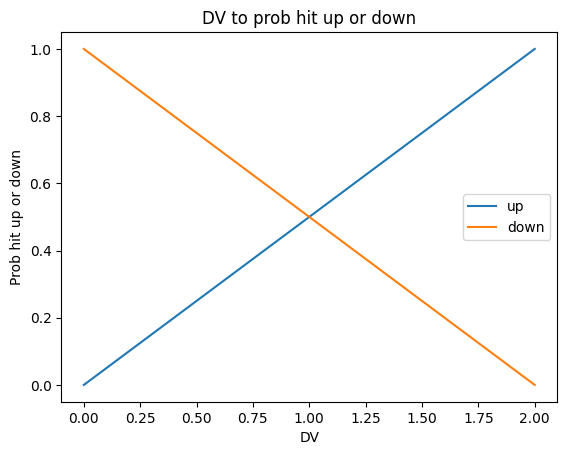

In [6]:
DV_pts = np.linspace(0, 2, 100)
dv_up = [DV_to_prob_hit_up_map(dv, L) for dv in DV_pts]
dv_down = [DV_to_prob_hit_down_map(dv, L) for dv in DV_pts]
plt.plot(DV_pts, dv_up, label='up')
plt.plot(DV_pts, dv_down, label='down')
plt.xlabel('DV')
plt.ylabel('Prob hit up or down')
plt.legend()
plt.title('DV to prob hit up or down');

# prob of hitting upper bound

In [7]:
def prob_x_t_and_hit_up(x, t, V_E, theta_E, Z, K_max, L):
    """
    Given x and t, return the probability of hitting the upper bound
    """
    P_x = P_x_small_t_fn(x, t, V_E, theta_E, Z, K_max)
    P_hit = DV_to_prob_hit_up_map(x, L)
    
    return P_x*P_hit

In [8]:
def prob_x_t_and_hit_down(x, t, V_E, theta_E, Z, K_max, L):
    """
    Given x and t, return the probability of hitting the lower bound
    """
    P_x = P_x_small_t_fn(x, t, V_E, theta_E, Z, K_max)
    P_hit = DV_to_prob_hit_down_map(x, L)
    
    return P_x*P_hit

# numeric

In [9]:
t_pts = np.linspace(0.001, 2, 100)
prob_hit_up_numeric = np.zeros_like(t_pts)

for i, t in enumerate(t_pts):
    prob_hit_up_numeric[i] = quad(prob_x_t_and_hit_up, 0, 2, args=(t, V_E, theta_E, Z_E, K_max, L))[0]

In [10]:
prob_down_numeric = np.zeros_like(t_pts)

for i,t in enumerate(t_pts):
    prob_down_numeric[i] = quad(prob_x_t_and_hit_down, 0, 2, args=(t, V_E, theta_E, Z_E, K_max, L))[0]

# analytic

In [11]:
def integral_of_exp_term_times_x(x, A, B):
    """
    Integral of exp(-(x+A)^2 / B) * x * dx 
    """
    return (-B/2)*np.exp( -((x + A)**2)/B ) - (A*np.sqrt(np.pi*B)/2)*erf( (x + A)/np.sqrt(B) )

def integral_of_exp_term(x, A, B):
    """
    Integral of exp(-(x+A)^2 / B) * dx
    """
    return (np.sqrt(np.pi*B)/2) * erf( (x + A)/np.sqrt(B) )

In [12]:
def Phi(x):
    """
    Define the normal cumulative distribution function Φ(x) using erf
    """
    return 0.5 * (1 + erf(x / np.sqrt(2)))

def P_small_t_btn_x1_x2(x1, x2, t, V_E, theta_E, Z, n_max):
    """
    Integration of P_small(x,t) btn x1 and x2
    """
    v = V_E
    mu = v*theta_E
    z = 2 * (Z + theta_E)/(2*theta_E) # z is between 0 and 2

    t /= (theta_E**2)

    result = 0
    
    sqrt_t = np.sqrt(t)
    
    for n in range(-n_max, n_max + 1):
        term1 = np.exp(4 * mu * n) * (
            Phi((x2 - (z + 4 * n + mu * t)) / sqrt_t) -
            Phi((x1 - (z + 4 * n + mu * t)) / sqrt_t)
        )
        
        term2 = np.exp(2 * mu * (2 * (1 - n) - z)) * (
            Phi((x2 - (-z + 4 * (1 - n) + mu * t)) / sqrt_t) -
            Phi((x1 - (-z + 4 * (1 - n) + mu * t)) / sqrt_t)
        )
        
        result += term1 - term2
    
    return result

In [13]:
def prob_x_t_and_hit_up_analytic(t, V_E, theta_E, Z, N_max, L):
    """
    Given x and t, return the probability of hitting the upper bound
    """
    mu = V_E*theta_E
    z = (Z + theta_E)/(theta_E) # [-1,1] system to [0,2] system
    t /= theta_E**2

    term1 = 1/np.sqrt(2*np.pi*t)
    n_terms = np.linspace(-N_max, N_max, 2*N_max+1)

    m = 1/L
    c = 0.5 - 1/L
    
    sum_term = 0
    B = 2*t

    for n in n_terms:
        exp1 = np.exp(4*mu*n)
        A1 = -z - 4*n - mu*t

        exp2 = np.exp(2*mu*(2 - 2*n - z))
        A2 = z - 4*(1-n) - mu*t


        # exp_term * exp((x + A)**2 / B ) * mx +  exp_term * exp((x + A)**2 / B ) * c
        sum_term += exp1*m*integral_of_exp_term_times_x(1+(L/2), A1, B) + exp1*c*integral_of_exp_term(1+(L/2), A1, B) \
                    - exp2*m*integral_of_exp_term_times_x(1+(L/2), A2, B) - exp2*c*integral_of_exp_term(1+(L/2), A2, B) \
                    - (
                        exp1*m*integral_of_exp_term_times_x(1-(L/2), A1, B) + exp1*c*integral_of_exp_term(1-(L/2), A1, B) \
                        - exp2*m*integral_of_exp_term_times_x(1-(L/2), A2, B) - exp2*c*integral_of_exp_term(1-(L/2), A2, B)

                        )
        
    
    return term1*sum_term  + P_small_t_btn_x1_x2(1+L/2, 2, t, V_E, theta_E, Z_E, N_max)

In [14]:
def prob_x_t_and_hit_down_analytic(t, V_E, theta_E, Z, N_max, L):
    """
    Given x and t, return the probability of hitting the upper bound
    """
    mu = V_E*theta_E
    z = (Z + theta_E)/(theta_E) # [-1,1] system to [0,2] system
    t /= theta_E**2

    term1 = 1/np.sqrt(2*np.pi*t)
    n_terms = np.linspace(-N_max, N_max, 2*N_max+1)

    m = -1/L
    c = 0.5 + 1/L
    
    sum_term = 0
    B = 2*t

    for n in n_terms:
        exp1 = np.exp(4*mu*n)
        A1 = -z - 4*n - mu*t

        exp2 = np.exp(2*mu*(2 - 2*n - z))
        A2 = z - 4*(1-n) - mu*t


        # exp_term * exp((x + A)**2 / B ) * mx +  exp_term * exp((x + A)**2 / B ) * c
        sum_term += exp1*m*integral_of_exp_term_times_x(1+(L/2), A1, B) + exp1*c*integral_of_exp_term(1+(L/2), A1, B) \
                    - exp2*m*integral_of_exp_term_times_x(1+(L/2), A2, B) - exp2*c*integral_of_exp_term(1+(L/2), A2, B) \
                    - (
                        exp1*m*integral_of_exp_term_times_x(1-(L/2), A1, B) + exp1*c*integral_of_exp_term(1-(L/2), A1, B) \
                        - exp2*m*integral_of_exp_term_times_x(1-(L/2), A2, B) - exp2*c*integral_of_exp_term(1-(L/2), A2, B)

                        )
        
    
    return term1*sum_term  + P_small_t_btn_x1_x2(0, 1-L/2, t, V_E, theta_E, Z_E, N_max)

In [15]:
def prob_hit_up_or_down_analytic_fn(t, V_E, theta_E, Z, N_max, L, bound):
    """
    Given x and t, return the probability of hitting the upper bound/lower bound
    """
    mu = V_E*theta_E
    z = (Z + theta_E)/(theta_E) # [-1,1] system to [0,2] system
    t /= theta_E**2

    term1 = 1/np.sqrt(2*np.pi*t)
    n_terms = np.linspace(-N_max, N_max, 2*N_max+1)

    if bound == 1:
        m = 1/L
        c = 0.5 - 1/L
    elif bound == -1:
        m = -1/L
        c = 0.5 + 1/L
    
    sum_term = 0
    B = 2*t

    for n in n_terms:
        exp1 = np.exp(4*mu*n)
        A1 = -z - 4*n - mu*t

        exp2 = np.exp(2*mu*(2 - 2*n - z))
        A2 = z - 4*(1-n) - mu*t


        # exp_term * exp((x + A)**2 / B ) * mx +  exp_term * exp((x + A)**2 / B ) * c
        sum_term += exp1*m*integral_of_exp_term_times_x(1+(L/2), A1, B) + exp1*c*integral_of_exp_term(1+(L/2), A1, B) \
                    - exp2*m*integral_of_exp_term_times_x(1+(L/2), A2, B) - exp2*c*integral_of_exp_term(1+(L/2), A2, B) \
                    - (
                        exp1*m*integral_of_exp_term_times_x(1-(L/2), A1, B) + exp1*c*integral_of_exp_term(1-(L/2), A1, B) \
                        - exp2*m*integral_of_exp_term_times_x(1-(L/2), A2, B) - exp2*c*integral_of_exp_term(1-(L/2), A2, B)

                        )
        
    
    return term1*sum_term 

# calculate analytic

In [16]:
prob_hit_up_analytic = np.zeros_like(t_pts)
for i, t in enumerate(t_pts):
    prob_hit_up_analytic[i] = prob_hit_up_or_down_analytic_fn(t, V_E, theta_E, Z_E, K_max, L, 1)

In [17]:
prob_hit_down_analytic = np.zeros_like(t_pts)
for i, t in enumerate(t_pts):
    prob_hit_down_analytic[i] = prob_hit_up_or_down_analytic_fn(t, V_E, theta_E, Z_E, K_max, L, -1)


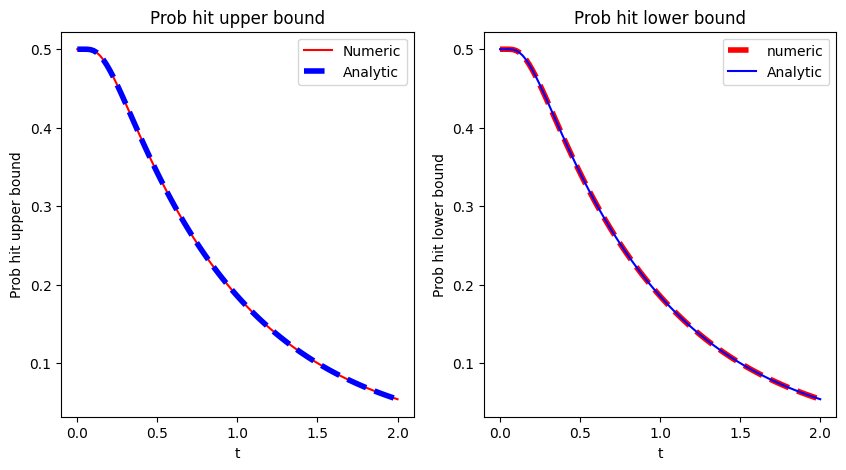

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(t_pts, prob_hit_up_numeric, label='Numeric', color='r')
plt.plot(t_pts, prob_hit_up_analytic, label='Analytic', color='b', linestyle='--', lw=4)
plt.xlabel('t')
plt.ylabel('Prob hit upper bound')
plt.title('Prob hit upper bound')
plt.legend();

plt.subplot(1,2,2)
plt.plot(t_pts, prob_down_numeric, label='numeric', color='r', linestyle='--', lw=4)
plt.plot(t_pts, prob_hit_down_analytic ,label='Analytic', color='b')
plt.xlabel('t')
plt.ylabel('Prob hit lower bound')
plt.title('Prob hit lower bound')
plt.legend();

/tmp/ipykernel_1961708/3823644779.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(p1, DV_pts)


Text(0, 0.5, 'Prob hit up or down')

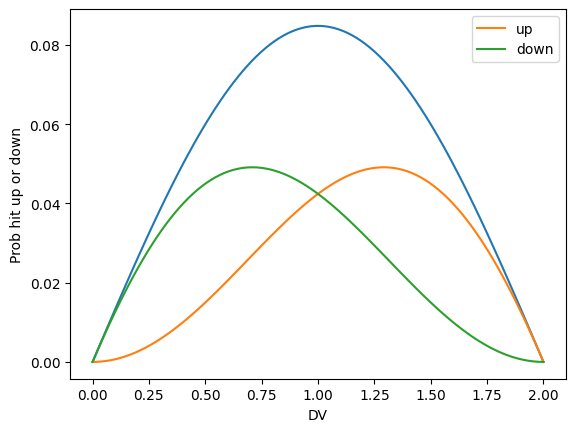

In [19]:
px = np.array([P_x_small_t_fn(d, t, V_E, theta_E, Z_E, K_max) for d in DV_pts])
plt.plot(DV_pts, px);

p_up = np.array([DV_to_prob_hit_up_map(dv, L) for dv in DV_pts])
p_down = np.array([DV_to_prob_hit_down_map(dv, L) for dv in DV_pts])

plt.plot(DV_pts, px*p_up, label='up')
plt.plot(DV_pts, px*p_down, label='down')

p1 = px*p_up

# area under p1
area = np.trapz(p1, DV_pts)
plt.legend();
plt.xlabel('DV')
plt.ylabel('Prob hit up or down')


# Summary

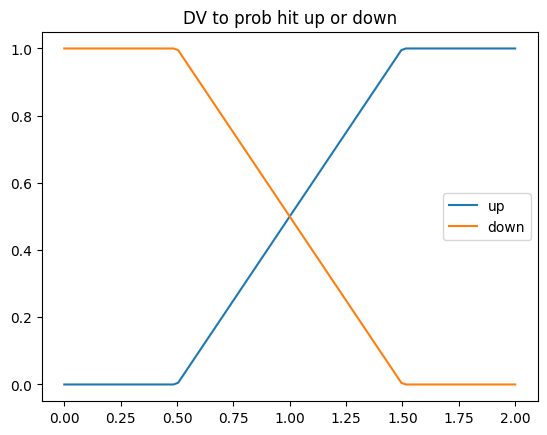

As per PSIAM, when proactive process hits its bound the DV is between 0 and 1, lower bound is hit.  And when proactive process hits its bound and DV is between 1 and 2, upper bound is hit.

But DV just above positive always resulting in upper bound hit is not convincing.
Hence, we can replace the idea of  "definitely hitting upper or lower bound based on sign of DV" with "probability of hitting upper or lower bound based on DV".

The simplest possible probability map is linear map as shown in above figure. At 1, probability of hitting any bound is 0.5. At $1 - \frac{L}{2}$, probability of hitting upper bound is 0, and it linear increases to 1 at $DV = 1 + \frac{L}{2}$. Similarly, the probability of hitting lower bound at $DV = 1 - \frac{L}{2}$ is 1 and it linearly decreases to 0 at $DV = 1 + \frac{L}{2}$.

Complication arises in this part

Previously as per PSIAM, 
if proactive hits first 
probability of hitting upper bound = prob that DV is between 1 and 2

but now, prob of hitting upper bound = (Prob that DV is at x) times (Prob that at x, upper bound is hit)

Prob that at x, upper bound is hit is of form $y = mx + c$

So, we need to integrate $p_s(x,t) \cdot (mx + c) $  from $1 - \frac{L}{2}$ to $1 + \frac{L}{2}$

And if we want the prob of hitting up, then we add also prob that DV is between  $1 + \frac{L}{2}$ and 2. Similarly, if we want prob of hiting down, we also add prob that DV is between 0 and $1 - \frac{L}{2}$


For prob of hitting up, $ m = 1/L$  and $ c = 0.5 - 1/L$



Recap,
$p_s(x,t)$ is 

$ p_s(x,t) = \frac{1}{\sqrt{2 \pi t}} \sum_{n=-\infty}^{n=\infty} \bigg[ \exp\Big( 4\mu n - \frac{(x-z-4n-\mu t)^2}{2t}\Big) - \exp\Big( 2\mu[2(1-n)-z] - \frac{(x+z-4(1-n)-\mu t)^2}{2t}\Big) \bigg]$

it is of form
$p_s(x,t) = \frac{1}{\sqrt{2 \pi t}} \cdot \sum_{n=-\infty}^{n=\infty} (exp(4 \mu n) \cdot exp(-\frac{(x-A_1)^2}{B})$ - ( exp(2 \mu (2 - 2n - z)) \cdot exp(-\frac{(x-A_2)^2}{B}) )

where $A_1 = -z-4n-\mu t$, $A_2 = z - 4(1-n) - \mu t$, $B = 2t$

### Important integrals

[Reference](https://chatgpt.com/share/671275e7-3574-8002-95c3-e84ece94103d) 

$ \int exp(\frac{-(x - A)^2}{B}) = \frac{\sqrt{\pi B}}{2} erf(\frac{x + A}{\sqrt{B}})$

$ \int x \cdot exp(\frac{-(x - A)^2}{B}) = -\frac{B}{2} exp(-\frac{(x + A)^2}{B}) - \frac{A \sqrt{\pi B}}{2} erf(\frac{x + A}{\sqrt{B}})$


### Using above important integrals
$$
p_s(up) = \int_{1 - \frac{L}{2}}^{1 + \frac{L}{2}} p_s(x,t) (mx + c) \\
        = \int_{1 - \frac{L}{2}}^{1 + \frac{L}{2}} m \cdot p_s(x,t) \cdot x + c \cdot p_s(x,t)\\
        
        = 1/\sqrt{2 \pi t} \cdot [ \sum_{-\infty}^{\infty} exp(4 \mu n) \cdot m \cdot (-\frac{B}{2} exp(\frac{-(x + A_1)^2}{B}) -\frac{A_1 \sqrt{\pi B}}{2} erf(\frac{x + A_1}{\sqrt{B}}) ) \\
        
        + exp(4 \mu n) \cdot c \cdot \frac{\sqrt{\pi B}}{2} erf(\frac{x + A_1}{\sqrt{B})} \\
        
        - exp( 2 \mu (2 - 2n -z) ) \cdot m \cdot (-\frac{B}{2} exp(\frac{-(x + A_2)^2}{B}) -\frac{A_2 \sqrt{\pi B}}{2} erf(\frac{x + A_2}{\sqrt{B}}) ) \\

        - exp( 2 \mu (2 - 2n -z) ) \cdot c \cdot \frac{\sqrt{\pi B}}{2} erf(\frac{x + A_2}{\sqrt{B}})
        
        ]_{1 - L/2}^{1 + L/2}
        
$$

